<a href="https://colab.research.google.com/github/SohilaOsama/eicu-code/blob/master/withFS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade category_encoders

     |████████████████████████████████| 82 kB 355 kB/s 


In [ ]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, plot_confusion_matrix, auc
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
#XGBOOST

**LoadData**

In [ ]:
data0=pd.read_csv('/content/data01.csv')
data0[0:3].T

,0,1,2
group,1.000000,1.000000,1.000000
ID,125047.000000,139812.000000,109787.000000
outcome,0.000000,0.000000,0.000000
age,72.000000,75.000000,83.000000
gendera,1.000000,2.000000,2.000000
BMI,37.588179,NaN,26.572634
hypertensive,0.000000,0.000000,0.000000
atrialfibrillation,0.000000,0.000000,0.000000
CHD with no MI,0.000000,0.000000,0.000000
diabetes,1.000000,0.000000,0.000000


In [ ]:
data0=data0.drop(['group','ID'],axis=1)

In [ ]:
print(data0.columns.tolist())
print(data0.info())

['outcome', 'age', 'gendera', 'BMI', 'hypertensive', 'atrialfibrillation', 'CHD with no MI', 'diabetes', 'deficiencyanemias', 'depression', 'Hyperlipemia', 'Renal failure', 'COPD', 'heart rate', 'Systolic blood pressure', 'Diastolic blood pressure', 'Respiratory rate', 'temperature', 'SP O2', 'Urine output', 'hematocrit', 'RBC', 'MCH', 'MCHC', 'MCV', 'RDW', 'Leucocyte', 'Platelets', 'Neutrophils', 'Basophils', 'Lymphocyte', 'PT', 'INR', 'NT-proBNP', 'Creatine kinase', 'Creatinine', 'Urea nitrogen', 'glucose', 'Blood potassium', 'Blood sodium', 'Blood calcium', 'Chloride', 'Anion gap', 'Magnesium ion', 'PH', 'Bicarbonate', 'Lactic acid', 'PCO2', 'EF']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   outcome                   1177 non-null   int64  
 1   age                       1177 non-null   int64  
 2   gendera  

In [ ]:
data0['BMI'].fillna(data0['BMI'].mean(), inplace = True)
data0['heart rate'].fillna(data0['heart rate'].mean(), inplace = True)
data0['Systolic blood pressure'].fillna(data0['Systolic blood pressure'].mean(), inplace = True)
data0['Diastolic blood pressure'].fillna(data0['Diastolic blood pressure'].mean(), inplace = True)
data0['Respiratory rate'].fillna(data0['Respiratory rate'].mean(), inplace = True)
data0['SP O2'].fillna(data0['SP O2'].mean(), inplace = True)
data0['Urine output'].fillna(data0['Urine output'].median(), inplace = True)
data0['Neutrophils'].fillna(data0['Neutrophils'].mean(), inplace = True)
data0['Basophils'].fillna(data0['Basophils'].median(), inplace = True)
data0['Lymphocyte'].fillna(data0['Lymphocyte'].median(), inplace = True)
data0['PT'].fillna(data0['PT'].mean(), inplace = True)
data0['INR'].fillna(data0['INR'].median(), inplace = True)
data0['Creatine kinase'].fillna(data0['Creatine kinase'].median(), inplace = True)
data0['glucose'].fillna(data0['glucose'].mean(), inplace = True)
data0['Blood calcium'].fillna(data0['Blood calcium'].mean(), inplace = True)
data0['PH'].fillna(data0['PH'].mean(), inplace = True)
data0['Lactic acid'].fillna(data0['Lactic acid'].median(), inplace = True)
data0['PCO2'].fillna(data0['PCO2'].mean(), inplace = True)
data0['temperature'].fillna(data0['temperature'].mean(), inplace = True)


print(data0.isnull().sum())

outcome                     0
age                         0
gendera                     0
BMI                         0
hypertensive                0
atrialfibrillation          0
CHD with no MI              0
diabetes                    0
deficiencyanemias           0
depression                  0
Hyperlipemia                0
Renal failure               0
COPD                        0
heart rate                  0
Systolic blood pressure     0
Diastolic blood pressure    0
Respiratory rate            0
temperature                 0
SP O2                       0
Urine output                0
hematocrit                  0
RBC                         0
MCH                         0
MCHC                        0
MCV                         0
RDW                         0
Leucocyte                   0
Platelets                   0
Neutrophils                 0
Basophils                   0
Lymphocyte                  0
PT                          0
INR                         0
NT-proBNP 

In [ ]:
target=['outcome']
dataY=data0[target]
dataX=data0.drop('outcome',axis=1)

In [ ]:
n=len(data0)
print(n)

1177


In [ ]:
N=list(range(n))
random.seed(42)
random.shuffle(N)

In [ ]:
test_size = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(dataX, dataY, test_size = test_size,random_state=7)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(823, 48)
(354, 48)


In [ ]:
df_columns = list(dataX.columns)
print(df_columns)

['age', 'gendera', 'BMI', 'hypertensive', 'atrialfibrillation', 'CHD with no MI', 'diabetes', 'deficiencyanemias', 'depression', 'Hyperlipemia', 'Renal failure', 'COPD', 'heart rate', 'Systolic blood pressure', 'Diastolic blood pressure', 'Respiratory rate', 'temperature', 'SP O2', 'Urine output', 'hematocrit', 'RBC', 'MCH', 'MCHC', 'MCV', 'RDW', 'Leucocyte', 'Platelets', 'Neutrophils', 'Basophils', 'Lymphocyte', 'PT', 'INR', 'NT-proBNP', 'Creatine kinase', 'Creatinine', 'Urea nitrogen', 'glucose', 'Blood potassium', 'Blood sodium', 'Blood calcium', 'Chloride', 'Anion gap', 'Magnesium ion', 'PH', 'Bicarbonate', 'Lactic acid', 'PCO2', 'EF']


In [ ]:
train_df=X_train
test_df=X_test

In [ ]:
train_df.columns=df_columns
test_df.columns=df_columns

In [ ]:
def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

In [ ]:
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None
    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [ ]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        return out_df     

In [ ]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

  0%|          | 0/1 [00:00<?, ?it/s]


createcreate_numeric_feature  0.002[s]


  0%|          | 0/1 [00:00<?, ?it/s]

createcreate_numeric_feature  0.003[s]


In [ ]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv, 
             params: dict=None, 
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
          clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)
          pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()
        score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [ ]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}

In [ ]:
y = Y_train
print(y.shape)
ydf=pd.DataFrame(y)
ydf

(823, 1)


,outcome
408,0
725,0
148,1
412,0
886,1
...,...
919,0
211,0
502,0
537,0


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[26]	valid_0's rmse: 0.274529
fit fold=0  0.718[s]
Fold 0 RMSLE: 0.2745

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[20]	valid_0's rmse: 0.325495
fit fold=1  0.756[s]
Fold 1 RMSLE: 0.3255

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[40]	valid_0's rmse: 0.3347
fit fold=2  0.944[s]
Fold 2 RMSLE: 0.3347

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[17]	valid_0's rmse: 0.300104
fit fold=3  0.173[s]
Fold 3 RMSLE: 0.3001

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[18]	valid_0's rmse: 0.327708
fit fold=4  0.179[s]
Fold 4 RMSLE: 0.3277

--------------------------------------------------
FINISHED | Whole RMSLE: 0.3133


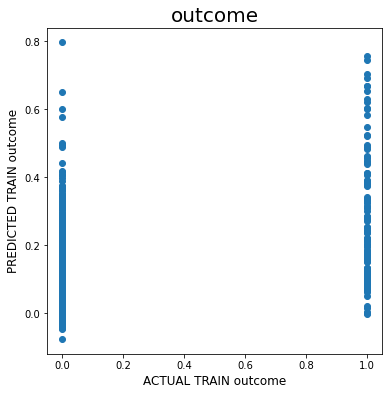

In [ ]:
from sklearn.model_selection import KFold

for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title(target[i],fontsize=20)
    ax.set_xlabel('ACTUAL TRAIN '+target[i],fontsize=12)
    ax.set_ylabel('PREDICTED TRAIN '+target[i],fontsize=12)
    ax.scatter(y,oof)

In [ ]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]
    
    print()
    print(order[0:9].tolist())
    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    
    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig,ax

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[15]	valid_0's rmse: 0.317066
fit fold=0  0.619[s]
Fold 0 RMSLE: 0.3171

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[27]	valid_0's rmse: 0.356042
fit fold=1  1.491[s]
Fold 1 RMSLE: 0.3560

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[44]	valid_0's rmse: 0.294165
fit fold=2  0.528[s]
Fold 2 RMSLE: 0.2942

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[16]	valid_0's rmse: 0.312432
fit fold=3  0.225[s]
Fold 3 RMSLE: 0.3124

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[18]	valid_0's rmse: 0.291289
fit fold=4  0.165[s]
Fold 4 RMSLE: 0.2913

--------------------------------------------------
FINISHED | Whole RMSLE: 0.3151

['Leucocyte', 'Lactic acid', 'Bicarbonate', 'Platelets', 'Anio

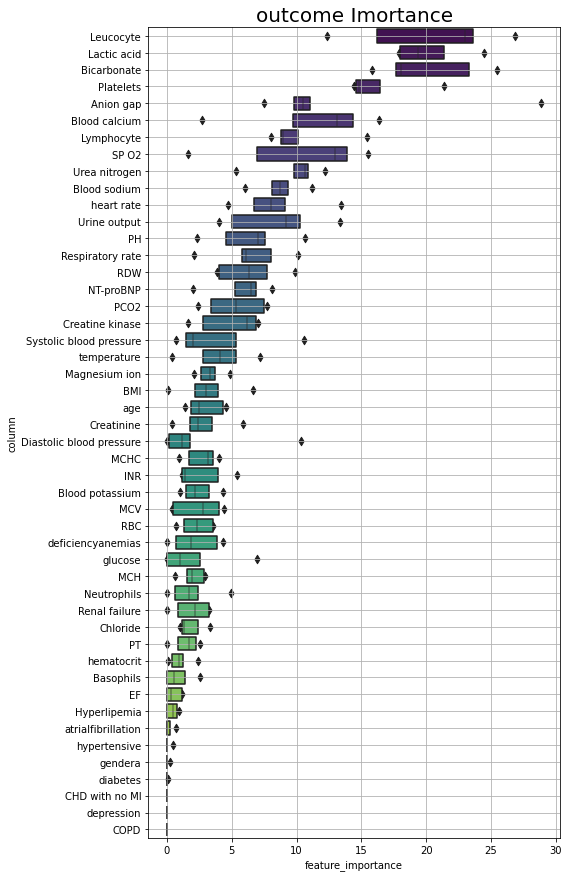

In [ ]:
pred1=[]
for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=42)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(target[i]+' Imortance',fontsize=20)
    pred0 = np.array([model.predict(test_feat_df.values) for model in models])
    pred1+=[np.mean(pred0, axis=0)]

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


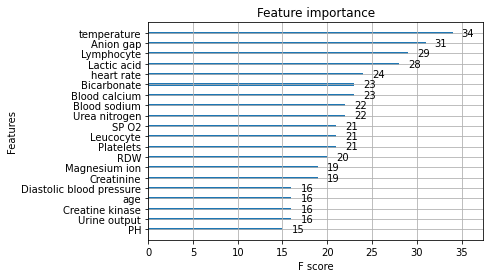

In [ ]:
# fit model no training data
model = XGBClassifier()
model.fit(dataX, dataY)

# plot feature importance
plot_importance(model,max_num_features=20)
pyplot.show()

In [ ]:
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

In [ ]:
model = XGBClassifier()
model.fit(X_train, Y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, Y_train)
    
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(Y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 88.14%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/di

Thresh=0.000, n=48, Accuracy: 88.14%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Thresh=0.000, n=48, Accuracy: 88.14%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Thresh=0.000, n=48, Accuracy: 88.14%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Thresh=0.000, n=48, Accuracy: 88.14%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Thresh=0.000, n=48, Accuracy: 88.14%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Thresh=0.000, n=48, Accuracy: 88.14%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Thresh=0.011, n=42, Accuracy: 88.14%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Thresh=0.012, n=41, Accuracy: 88.42%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Thresh=0.013, n=40, Accuracy: 88.70%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Thresh=0.014, n=39, Accuracy: 88.70%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Thresh=0.014, n=38, Accuracy: 88.70%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Thresh=0.015, n=37, Accuracy: 88.14%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Thresh=0.016, n=36, Accuracy: 88.70%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Thresh=0.016, n=35, Accuracy: 88.14%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Thresh=0.016, n=34, Accuracy: 88.70%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Thresh=0.016, n=33, Accuracy: 88.98%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Thresh=0.016, n=32, Accuracy: 88.98%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Thresh=0.017, n=31, Accuracy: 88.70%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Thresh=0.018, n=30, Accuracy: 87.57%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/di

Thresh=0.018, n=29, Accuracy: 88.42%
Thresh=0.019, n=28, Accuracy: 87.57%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/di

Thresh=0.019, n=27, Accuracy: 88.14%
Thresh=0.020, n=26, Accuracy: 88.42%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/di

Thresh=0.021, n=25, Accuracy: 88.98%
Thresh=0.021, n=24, Accuracy: 88.14%


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/di

Thresh=0.022, n=23, Accuracy: 88.14%
Thresh=0.023, n=22, Accuracy: 88.70%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/di

Thresh=0.024, n=21, Accuracy: 88.14%
Thresh=0.024, n=20, Accuracy: 87.85%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/di

Thresh=0.024, n=19, Accuracy: 87.29%
Thresh=0.025, n=18, Accuracy: 87.29%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/di

Thresh=0.025, n=17, Accuracy: 86.72%
Thresh=0.026, n=16, Accuracy: 87.57%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/di

Thresh=0.026, n=15, Accuracy: 88.14%
Thresh=0.027, n=14, Accuracy: 88.14%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/di

Thresh=0.028, n=13, Accuracy: 88.14%
Thresh=0.029, n=12, Accuracy: 87.57%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/di

Thresh=0.029, n=11, Accuracy: 87.29%
Thresh=0.031, n=10, Accuracy: 87.01%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/di

Thresh=0.032, n=9, Accuracy: 86.44%
Thresh=0.032, n=8, Accuracy: 87.57%
Thresh=0.033, n=7, Accuracy: 87.01%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/di

Thresh=0.034, n=6, Accuracy: 87.57%
Thresh=0.035, n=5, Accuracy: 87.29%
Thresh=0.036, n=4, Accuracy: 88.14%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/di

Thresh=0.036, n=3, Accuracy: 87.29%
Thresh=0.038, n=2, Accuracy: 87.85%
Thresh=0.051, n=1, Accuracy: 86.72%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
